In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

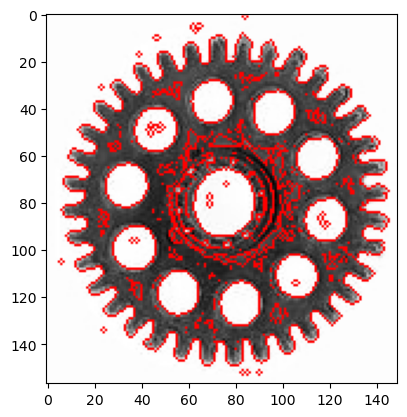

In [2]:
img = cv2.imread("trybik.jpg", cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

bin_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(bin_img, cmap='gray')

contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contours = contours[1:]
hierarchy = hierarchy[0][1:]

cv2.drawContours(img_rgb, contours, -1, (255, 0, 0), 0)

plt.imshow(img_rgb)

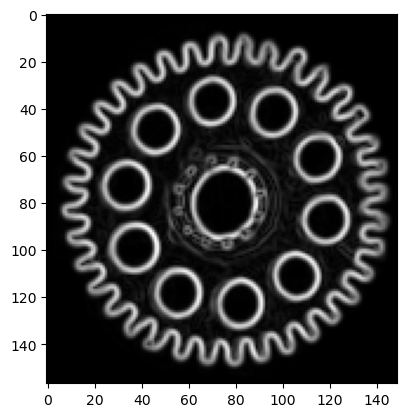

In [3]:
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

sobel = np.sqrt(sobelx**2 + sobely**2)
# normalize
sobel = sobel/np.amax(sobel)

# gradient orientation
theta = np.arctan2(sobely, sobelx)

plt.imshow(sobel, cmap='gray')

In [4]:
moments = cv2.moments(bin_img, 1)
m00 = moments['m00']
m01 = moments['m01']
m10 = moments['m10']

# center of mass
center = (int(m01/m00), int(m10/m00))

In [5]:
# Do wypełnienia R-table b˛ed ˛a potrzebne wektory ł ˛acz ˛ace punkty konturu/konturów
# z punktem referencyjnym. Do R-table wpisujemy długo´sci tych wektorów oraz k ˛aty
# jakie tworz ˛a z osi ˛a OX (tu znów przyda si˛e funkcja np.arctan2). Miejsce wpisania
# do tablicy R-table wyznacza orientacja gradientu w punkcie konturu (wyznaczona na
# podstawie filtracji maskami Sobela), przy czym prosz˛e przeliczy´c radiany na stopnie –
# R-table b˛edzie miała 360 wierszy. Stosujemy dokładno´s´c wynosz ˛ac ˛a 1 stopie´n. R-table
# mo˙zna zaimplementowa´c jako list˛e 360 list
# Wówczas np. Rtable[30] b˛edzie list ˛a współrz˛ednych biegunowych punktów konturu,
# których orientacja wyliczona na podstawie gradientów wynosi około 30◦

R_table = [ [] for _ in range(360) ]

for contour in contours:
    for point in contour:
        x = point[0][0]
        y = point[0][1]
        dx = x - center[0]
        dy = y - center[1]
        r = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx) * 180/np.pi
        if angle < 0:
            angle += 360
        R_table[int(angle)].append(r)

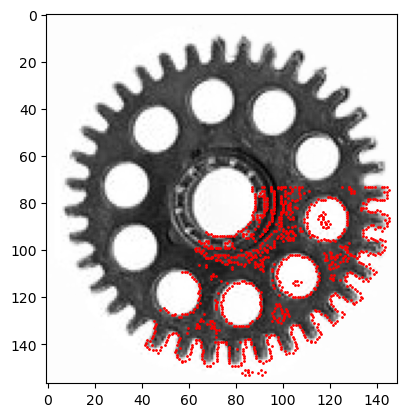

In [6]:
def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

x_points = []
y_points = []

ang_range = 120

for angle, radiuses in enumerate(R_table[:ang_range]):
    for radius in radiuses:
        x, y = polar_to_cartesian(radius, np.radians(angle))  # Converting angle to radians
        x_points.append(x + center[0])  # Add centroid offset
        y_points.append(y + center[1])  # Add centroid offset

plt.imshow(img, cmap='gray')
plt.plot(x_points, y_points, 'ro', markersize=1)

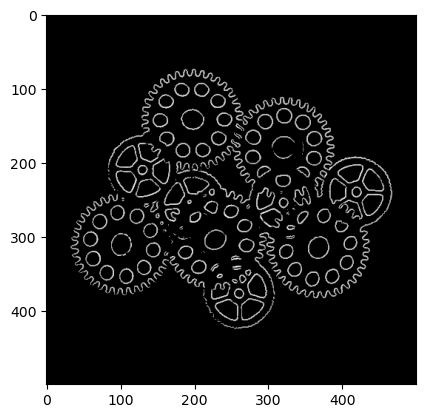

In [7]:
# Na podstawie obrazu trybiki2.jpg oraz R-table z poprzedniego punktu wypełnij
# dwuwymiarow ˛a przestrze´n Hougha – wylicz ponownie gradient w ka˙zdym punkcie i dla
# punktów, których znormalizowana warto´s´c gradientu przekracza 0.5 , okre´sl orientacj˛e
# w tym punkcie, a nast˛epnie zwi˛eksz warto´s´c o 1 w przestrzeni akumulacyjnej w punktach
# zapisanych w R-table według zale˙zno´sci:
# x1 = -r * np . cos ( fi ) + x
# y1 = -r * np . sin ( fi ) + y

img2 = cv2.imread("trybiki2.jpg", cv2.IMREAD_GRAYSCALE)

sobelx2 = cv2.Sobel(img2, cv2.CV_64F, 1, 0, ksize=5)
sobely2 = cv2.Sobel(img2, cv2.CV_64F, 0, 1, ksize=5)

sobel2 = np.sqrt(sobelx2**2 + sobely2**2)
# normalize
sobel2 = sobel2/np.amax(sobel2)

# get rid of values below 0.5
sobel2[sobel2 < 0.5] = 0

# gradient orientation
theta2 = np.arctan2(sobely2, sobelx2)

plt.imshow(sobel2, cmap='gray')

100%|██████████| 500/500 [01:27<00:00,  5.72it/s]


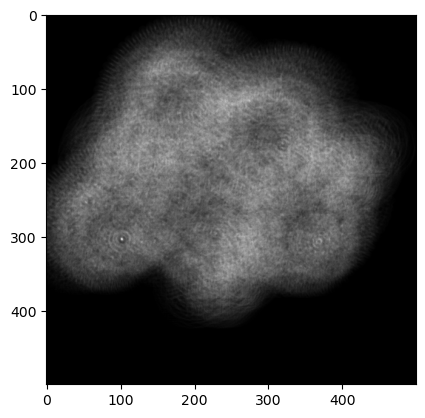

In [9]:
H = np.zeros((img2.shape[0], img2.shape[1]))

from tqdm.auto import tqdm

for y in tqdm(range(img2.shape[0])):
    for x in range(img2.shape[1]):
        if sobel2[y, x] > 0:
            for angle, radiuses in enumerate(R_table[:ang_range]):
                for radius in radiuses:
                    x1 = int(-radius * np.cos(np.radians(angle)) + x)
                    y1 = int(-radius * np.sin(np.radians(angle)) + y)
                    if 0 <= x1 < img2.shape[1] and 0 <= y1 < img2.shape[0]:
                        H[y1, x1] += 1

plt.imshow(H, cmap='gray')

In [10]:
find_max = np.where(H == H.max())

(array([304]), array([102]))

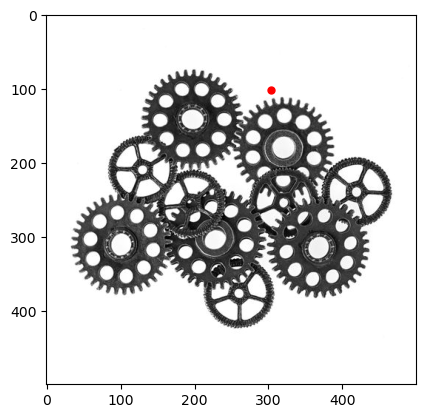

In [18]:
plt.imshow(img2, cmap='gray')
plt.plot([find_max[0]], [find_max[1]], 'ro', markersize=5)
